# Publication database
Create a database that tracks publications and their authors in order

In [1]:
import datajoint as dj

In [2]:
schema = dj.schema('dimitri_publications')
schema.drop()
schema = dj.schema('dimitri_publications')

Connecting dimitri@db.data-science-ust.net:3306
Proceed to delete entire schema `dimitri_publications`? [yes, No]: yes


In [3]:
@schema
class Publication(dj.Manual):
    definition = """
    pub_id : int 
    ---
    title : varchar(1000)
    publish_date  : date 
    author : varchar(1000)
    """

In [4]:
import faker
faker = faker.Faker()

In [5]:
for i in range(30):
    Publication.insert1(dict(
        pub_id=i, title=faker.sentence(), 
        publish_date=faker.date_this_decade(), author=faker.name()), skip_duplicates=True)

In [6]:
Publication()

pub_id,title,publish_date,author
0,Such loss authority within upon card if.,2020-06-06,Anthony Kim
1,By its age food bar the.,2020-08-21,Barbara Chambers
2,Defense between time social fish.,2020-08-16,Joy Hughes
3,Likely collection cold.,2020-01-11,Nicole Faulkner
4,Population determine let operation purpose from star vote.,2020-06-19,Leah Clements
5,Cold amount ahead small.,2020-09-29,Donald Turner
6,High whole his could cost.,2020-02-19,Ryan Harris
7,Family successful down dark.,2020-01-12,Michael Petty
8,Present them recently through claim address may manage.,2020-04-15,Michael Perez
9,Wind hard report weight central discussion.,2020-01-08,James Hooper


# New design. Many-many publication/author

In [7]:
schema.drop()
schema = dj.schema('dimitri_publications')

Proceed to delete entire schema `dimitri_publications`? [yes, No]: yes


In [8]:
@schema 
class Author(dj.Manual):
    definition = """
    author_id : int 
    ---
    first_name : varchar(100)
    last_name : varchar(100)
    """

In [9]:
for i in range(100):
    Author.insert1(dict(author_id=i, 
                        first_name=faker.first_name(), 
                        last_name=faker.last_name()))  

In [10]:
# same thing but faster
Author.insert((
    dict(
        author_id=i, 
        first_name=faker.first_name(), 
        last_name=faker.last_name()) for i in range(100))
    , skip_duplicates=True)

In [11]:
Author()

author_id,first_name,last_name
0,John,Johns
1,Joseph,Griffin
2,Kimberly,Gibbs
3,Juan,Martinez
4,Joshua,Evans
5,Henry,Wilson
6,Ronald,Hahn
7,Karen,Douglas
8,Shelly,Jones
9,Shawn,Harper


In [12]:
@schema
class Publication(dj.Manual):
    definition = """
    pub_id : int 
    ---
    title : varchar(1000)
    publish_date  : date 
    """

In [13]:
Publication.insert([dict(
    pub_id=i, title=faker.sentence(), 
    publish_date=faker.date_this_decade()) for i in range(30)], skip_duplicates=True)

In [14]:
Publication()

pub_id,title,publish_date
0,Respond scientist well.,2020-03-08
1,Sit room herself collection true.,2020-08-30
2,Realize song race hot.,2020-01-09
3,Region seat factor trouble show around authority institution.,2020-05-29
4,Public box future magazine.,2020-01-27
5,Choose compare business pretty when.,2020-02-17
6,Music performance also charge bar plant education ability.,2020-05-19
7,Save lot sister sister mouth they.,2020-03-07
8,Explain newspaper behind radio.,2020-01-09
9,However us take parent.,2020-05-20


In [15]:
@schema
class PubAuthor(dj.Manual):
    definition = """
    -> Publication
    -> Author
    """

In [16]:
authors = Author.fetch("KEY")
pubs = Publication.fetch("KEY")

In [17]:
import random

In [18]:
for pub in pubs:
    for auth in random.sample(authors, random.randint(1, 3)):
        PubAuthor.insert1({**pub, **auth}, skip_duplicates=True)

In [19]:
PubAuthor()

pub_id,author_id
0,17
0,31
1,59
2,66
3,37
3,86
3,98
4,1
4,20
4,25


In [20]:
Publication * PubAuthor * Author & 'pub_id=6'

pub_id,author_id,title,publish_date,first_name,last_name
6,84,Music performance also charge bar plant education ability.,2020-05-19,Jonathan,Mccarthy


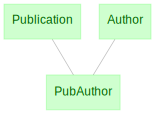

In [21]:
dj.Diagram(schema)

# Another design: Track the order of authors on the publication

In [22]:
PubAuthor.drop()

`dimitri_publications`.`pub_author` (58 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


In [23]:
@schema
class PubAuthor(dj.Manual):
    definition = """
    -> Publication
    -> Author
    ---
    author_order : tinyint 
    unique index(pub_id, author_order)
    """

In [24]:
for pub in pubs:
    for author_order, auth in enumerate(random.choices(authors, k=random.randint(1, 3))):
        PubAuthor.insert1(dict(**pub, **auth, author_order=author_order+1), skip_duplicates=True)

In [25]:
PubAuthor()

pub_id,author_id,author_order
0,22,1
1,35,1
1,59,2
2,46,1
2,98,2
2,59,3
3,28,1
3,93,2
4,96,1
4,89,2


# Cities, States, and Capitals

Design a database with
- Cities
- States
- State capitals


### Rules
1. A city belongs to a state
2. A state capital is a city in the same state
3. Only one city can be capital in each state
4. Cities and states have permanents names
5. Cities have unique names in each state

In [27]:
schema = dj.schema('dimitri_states')
schema.drop()  # drop to clear history
schema = dj.schema('dimitri_states')

Proceed to delete entire schema `dimitri_states`? [yes, No]: yes


In [28]:
@schema
class State(dj.Manual):
    definition = """
    state : char(2)  # TX, CA, etc
    ---
    state_name : varchar(25)
    """
    
State.insert((
    ("CA", "California"),
    ("TX", "Texas"),
    ("NY", "New York"),
    ("DE", "Delaware"),
    ("NE", "Nebraska"),
    ("MI", "Michigan"),
    ("WI", "Wisconsin"),
    ("PA", "Pensylvania")
), skip_duplicates=True)

In [29]:
State()

"state TX, CA, etc",state_name
CA,California
DE,Delaware
MI,Michigan
NE,Nebraska
NY,New York
PA,Pensylvania
TX,Texas
WI,Wisconsin


In [30]:
@schema
class City(dj.Manual):
    definition = """
    -> State  
    city_id : int
    ---
    city_name : varchar(100)  
    unique index (state, city_name)
    """

@schema
class Capital(dj.Manual):
    definition = """
    -> State
    ---
    -> City    
    """

#### Equivalent SQL to declare City

```sql
CREATE TABLE dimitri_state.city (
  state char(2) NOT NULL,
  city_id int NOT NULL,
  city_name varchar(100) NOT NULL,
  PRIMARY KEY (state, city_id),
  UNIQUE INDEX (state, city_name),
  FOREIGN KEY (state) REFERENCES state(state)
)
```

#### Equivalent SQL to declare Capital

```sql
CREATE TABLE dimitri_state.capital (
  state char(2) NOT NULL,
  city_id int NOT NULL,
  PRIMARY KEY (state),
  FOREIGN KEY (state, city_id) REFERENCE city(state, city_id),
  FOREIGN KEY (state) REFERENCES state(state)
)
```

In [31]:
City.insert(
    (
        ("TX", 1, "Houston"),
        ("TX", 2, "Austin"),
        ("DE", 1, "Dover"),
        ("DE", 2, "Wilmington"),
        ("CA", 1, "Sacramento"),
        ("CA", 2, "Houston"),
        ("CA", 3, "Los Angeles"),
        ("WI", 1, "Milwaukee"),
        ("WI", 2, "Madison"),
        ("CA", 4, "Madison")
    ))

Capital.insert((
    ("WI", 1),
    ("CA", 1),
    ("DE", 2),
    ("TX", 2),
))

In [32]:
Capital()

"state TX, CA, etc",city_id
CA,1
DE,2
TX,2
WI,1


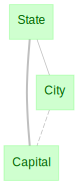

In [33]:
dj.Diagram(schema)

In [34]:
Capital()

"state TX, CA, etc",city_id
CA,1
DE,2
TX,2
WI,1


In [35]:
Capital()

"state TX, CA, etc",city_id
CA,1
DE,2
TX,2
WI,1


# Bank accounts and transfers

Design a database with 

- Customers
- Accounts with a current balance
- Deposits / Withdrawals 
- Transfers between accounts 
- Account balnace history

### Rules

1. A customer can have any number of accounts.
1. An account can have many customers
1. Overdrafts are not allowed: when attempting a withdrawal or transfer, the current balance is not allowed to go negative.
1. For a transfer, the credit from one account must match the debit from the other.

In [36]:
import faker
import random
fake = faker.Faker()

In [38]:
schema = dj.schema('dimitri_bank')
schema.drop()
schema = dj.schema('dimitri_bank')

Proceed to delete entire schema `dimitri_bank`? [yes, No]: yes


In [39]:
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int
    ---
    customer_name : varchar(100)
    ssn  :  char(11) 
    unique index (ssn) 
    """

In [40]:
Customer.insert((
    {'customer_id': i, 'customer_name': fake.name(), 'ssn': fake.ssn()}
               for i in range(30)))

In [41]:
Customer()

customer_id,customer_name,ssn
0,Jared Moore,580-82-5850
1,Cynthia Henry,626-07-2287
2,Lee Odonnell,798-03-4506
3,Jonathan Sparks,467-96-7004
4,Mary Maldonado,422-33-0730
5,Andre Lawson,279-81-4269
6,Jeffrey Valencia,584-46-5207
7,Matthew Roach,043-41-0211
8,Thomas Lopez,338-15-1970
9,Christine Woods,073-43-5226


In [42]:
@schema
class Account(dj.Manual):
    definition = """
    account_id : int
    ---
    account_type : enum("savings", "checking")
    open_date : date    
    """
    
@schema
class AccountCustomer(dj.Manual):
    definition = """
    -> Customer
    -> Account
    """    

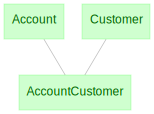

In [43]:
dj.Diagram(schema)

In [44]:
Account.insert(
    ({'account_id': i, 
      'open_date': fake.date_this_decade(), 
      'account_type': random.choice(("checking", "savings"))} for i in range(20)))

In [45]:
customers = Customer.fetch('KEY')
for a in Account.fetch('KEY'):
    AccountCustomer.insert(
        {**a, **c} for c in random.sample(customers, random.randint(1, 3)))

In [46]:
@schema
class Balance(dj.Manual):
    definition = """
    -> Account 
    ---
    amount : decimal(9, 2)
    """

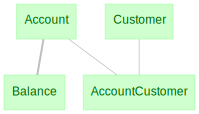

In [51]:
dj.Diagram(schema)

In [47]:
for a in Account.fetch('KEY'):
    Balance.insert1(dict(a, amount=random.randint(0, 120000)/100))

In [48]:
Balance()

account_id,amount
0,401.26
1,336.02
2,220.02
3,712.20
4,1160.50
5,277.59
6,438.60
7,843.88
8,964.95
9,427.98


In [49]:
def withdraw(key, amount):
    conn = dj.conn()
    with conn.transaction:
        previous_amount = (Balance & key).fetch1('amount')
        if amount > previous_amount: 
            raise ValueError('Insufficient funds')
        (Balance & key).delete_quick()
        # an error or disruption can happen here
        Balance.insert1(dict(key, amount=float(previous_amount) - amount))
    print('Remaining balance: {balance}'.format(balance=(Balance & key).fetch1('amount')))

In [50]:
key = {'account_id': 3}
withdraw(key, 50.00)

Remaining balance: 662.20


# Homework:  Hotel Database -- Due Nov 21.

Design a database with 

- Rooms
- Guests 
- Reservations
- Check-in:  date/time  for reservation
- Check-out: date/time  for reservation

### Rules
1. A reservation reserves one room for one night for one guest
2. A guest can reserve multiple rooms per night.
2. A guest must have a reservation to check in.
3. Checkout can only be done after a check-in. 
4. Checking into a room is allowed only after the previous guest checks out 

### Assignment
1. Design tables that enforce these rules
2. Populate with fake rooms, customers, and nights.
3. Define function `reserve` to make a reservation. Call it to make fake reservations.
3. Define functions `checkin` and `checkout`. Call them to demonstrate that they work. 
4. Use transactions if or when necessary